In [1]:
# What version of Python do you have?
import sys
import os
import tensorflow
import pandas as pd
import sklearn as sk
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Sequential
from matplotlib import pyplot as plt
%matplotlib inline

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.5.0
Keras Version: 2.5.0

Python 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
Pandas 1.3.3
Scikit-Learn 0.24.2
GPU is available


In [2]:
from tensorflow.keras.applications import ResNet152, InceptionV3

In [3]:
inceptionV3 = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape = (299, 299, 3)
)

for layer in inceptionV3.layers:
    layer.trainable = True

In [4]:
inceptionV3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [5]:
resnet152 = ResNet152(
    weights='imagenet',
    include_top=False,
    input_shape=((224, 224, 3))
)

for layer in resnet152.layers:
    layer.trainable = True

reshaping = layers.Reshape((8, 8, 1568))(resnet152.output)
re_config_resnet152 = tensorflow.keras.Model(inputs=resnet152.input, outputs=reshaping)

In [6]:
a = np.zeros(shape=(7, 7, 2048))
a = a.reshape(8, 8, 1568)
a.shape

(8, 8, 1568)

In [7]:
re_config_resnet152.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [8]:

# sort losses of batch descending order
# the largest k? is averaged as the final loss
# return loss
# parameters needed: SUM, label(i), loss of batches


def ohem_loss(ytrue, ypred):
    result = K.categorical_crossentropy(ytrue, ypred, axis=-1)
    alpha = K.variable(0.1, dtype=tf.float32)
    index = K.greater(result, alpha)
    cast = tf.cast(index, tf.float32)
    return result*cast

In [32]:
from tensorflow.keras import Model
from tensorflow.keras import backend as K


concat_feature_layer = layers.concatenate([inceptionV3.output, re_config_resnet152.output])
fully_connected_dense_big = layers.Dense(1024, activation='relu')(concat_feature_layer)
dropout_one = layers.Dropout(0.5)(fully_connected_dense_big)
flatten_layer = layers.Flatten()(dropout_one)
fully_connected_dense_small = layers.Dense(512, activation='relu')(flatten_layer)
dropout_two = layers.Dropout(0.5)(fully_connected_dense_small)
fully_connected_dense_class = layers.Dense(4, activation='softmax')(dropout_two)

model = Model(
    inputs=[inceptionV3.input, re_config_resnet152.input],
    outputs=fully_connected_dense_class
)

model.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    
)

model.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [10]:
modelplot = tensorflow.keras.utils.plot_model(model)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [11]:
print(os.getcwd())
path_to_windows = "./windows"

c:\Users\thoma\Desktop\speciale\DeepLearning_Master


In [12]:
resnet152_input_shape = (224, 224)
inceptionV3_input_shape = (299, 299)

In [13]:
labels = [item for item in os.listdir(path_to_windows)]
labels = np.array(labels)
labels = labels[0:]
print(labels.shape)
labels

(4,)


array(['Interictal', 'Preictal_One', 'Preictal_Two', 'Seizure'],
      dtype='<U12')

In [49]:
batch_size = 10

In [50]:
batch_data_generator_one = ImageDataGenerator(
rescale = 1./255, 
validation_split=0.2
)

batch_data_generator_two = ImageDataGenerator(
rescale = 1./255, 
validation_split=0.2
)


inceptionV3_train_set = batch_data_generator_one.flow_from_directory(
path_to_windows,
target_size=inceptionV3_input_shape,
color_mode='rgb',
batch_size=batch_size,
shuffle=False,
subset='training',
classes = list(labels)
)

inceptionV3_validation_set = batch_data_generator_one.flow_from_directory(
path_to_windows,
target_size=inceptionV3_input_shape,
color_mode='rgb',
batch_size=batch_size,
shuffle=False,
subset='validation',
classes = list(labels)
)

resnet_train_set = batch_data_generator_two.flow_from_directory(
path_to_windows,
target_size=resnet152_input_shape,
color_mode='rgb',
batch_size=batch_size,
shuffle=False,
subset='training',
classes = list(labels)
)

resnet_validation_set = batch_data_generator_two.flow_from_directory(
path_to_windows,
target_size=resnet152_input_shape,
color_mode='rgb',
batch_size=batch_size,
shuffle=False,
subset='validation',
classes = list(labels)
) 

def create_data_generator(incepV3_gen, resnet_gen):

    while(True):
        _gen1, _gen1_l = next(incepV3_gen)
        _gen2, _gen2_l = next(resnet_gen)

        yield [_gen1, _gen2], [_gen1_l]

multi_train_generator = create_data_generator(
    inceptionV3_train_set, 
    resnet_train_set
    )

multi_validation_generator = create_data_generator(
    inceptionV3_validation_set,
    resnet_validation_set
    )

Found 594459 images belonging to 4 classes.
Found 148612 images belonging to 4 classes.
Found 594459 images belonging to 4 classes.
Found 148612 images belonging to 4 classes.


In [52]:
def show_batch(image, label):
  plt.figure(figsize=(10,10))
  for n in range(0,10):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image[n])
      plt.title(labels[label[n].argmax()])
      plt.axis('off')

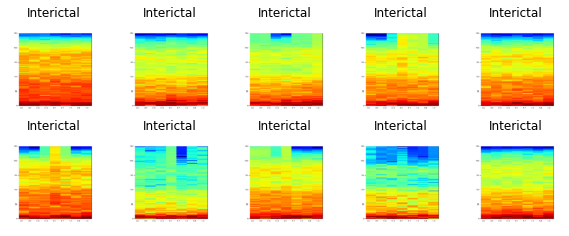

In [53]:
image, label = next(inceptionV3_train_set)
show_batch(image, label)

In [45]:
class TestCallback(tensorflow.keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x = self.test_data
        loss, acc = self.model.evaluate(x, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

In [47]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("best_model.h5", monitor='loss',
    save_best_only=True, mode='auto', save_freq=1, verbose=0)

In [54]:
history = model.fit(
    x=multi_train_generator,
    epochs=1,
    batch_size=batch_size,
    steps_per_epoch = inceptionV3_train_set.samples//batch_size,
    validation_steps=inceptionV3_validation_set.samples//batch_size,
    validation_data=multi_validation_generator,
    callbacks=[checkpoint]
)

ResourceExhaustedError:  OOM when allocating tensor with shape[10,128,17,17] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_3/batch_normalization_36/FusedBatchNormV3 (defined at \AppData\Local\Temp/ipykernel_20076/2502173947.py:1) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_91208]

Function call stack:
train_function


In [ ]:
model.save("fneur_model")